# Check outputs of MODIS_HRRR processing 
*J. Michelle Hu  
University of Utah  
August 2024*  
---

In [1]:
import os
import sys
import xarray as xr
import numpy as np

import pandas as pd
import matplotlib.pyplot as plt

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/env/')
import helpers as h

sys.path.append('/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/ucrb-isnobal/scripts/')


In [2]:
%reload_ext autoreload
%autoreload 2

In [3]:
# Set environmental variable for PROJ to directory where you can find proj.db
os.environ['PROJ']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'
os.environ['PROJLIB']='/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj'

## Directory

In [4]:
basin = 'blue_river'
# basin = 'yampa'
# basin = 'animas'

In [5]:
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'*{basin}*')
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal_solar_albedo']

In [6]:
# Get the WY from the directory name
WY = int(h.fn_list(basindirs[0], '*')[0].split('/')[-1].split('wy')[-1])
WY

2019

## Specify a point for evaluation

In [7]:
snotel_dir = '/uufs/chpc.utah.edu/common/home/skiles-group3/SNOTEL'

In [8]:
import processing as proc

In [9]:
from shapely.geometry import Point
import geopandas as gpd

# TODO: add data to locate snotel within basin
script_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/isnobal_scripts'

# Basin polygon file
poly_fn = h.fn_list(script_dir, f'*{basin}*setup/polys/*shp')[0]

# SNOTEL all sites geojson fn
allsites_fn = h.fn_list(snotel_dir, 'snotel_sites_32613.json')[0]

# Locate SNOTEL sites within basin
found_sites = proc.locate_snotel_in_poly(poly_fn=poly_fn, site_locs_fn=allsites_fn)

# Get site names and site numbers
site_names = found_sites['site_name']
sitenums = found_sites['site_num']

In [10]:
# Pull a point
# sitenum = '485' # Fremont pass
# sitenum = '709' # Rabbit Ears
# sitenum = '780' # Spud Mountain

jdx = 0
sitenum = sitenums.iloc[jdx]

# Get PoR if it doesn't exist
if len(h.fn_list(snotel_dir, f'*site{sitenum}.csv')) == 0:
    print(f'No record found for {sitenum}, need to download...')
    print(f'Run: get_snotelPoR_csv.sh {sitenum} from {snotel_dir}')

In [11]:
snotelfn = h.fn_list(snotel_dir, f'*site{sitenum}.csv')[0]

df = pd.read_csv(snotelfn, skiprows=63, usecols=list(np.arange(0, 7)), parse_dates=["Date"])
# Copy date to new date indexing column
df['DateIndex'] = df['Date']

# reset index as Date
df = df.set_index('DateIndex')

# Clip to this water year
snotel_df = df[(df['Date']>=f'{int(WY) - 1}-10-01') & (df['Date']<f'{WY}-10-01')]
snotel_df.head()

Date  \
DateIndex               
2018-10-01 2018-10-01   
2018-10-02 2018-10-02   
2018-10-03 2018-10-03   
2018-10-04 2018-10-04   
2018-10-05 2018-10-05   

            Copper Mountain (415) Snow Depth (cm) End of Day Values  \
DateIndex                                                             
2018-10-01                                                0.0         
2018-10-02                                                0.0         
2018-10-03                                                0.0         
2018-10-04                                                0.0         
2018-10-05                                                0.0         

            Copper Mountain (415) Snow Water Equivalent (mm) End of Day Values  \
DateIndex                                                                        
2018-10-01                                                0.0                    
2018-10-02                                                0.0                    
2018-10-03                                                0.0                    
2018-10-04                                                0.0                    
2018-10-05                                                0.0                    

            Copper Mountain (415) Snow Density (pct) End of Day Values  \
DateIndex                                                                
2018-10-01                                                NaN            
2018-10-02                                                NaN            
2018-10-03                                                NaN            
2018-10-04                                                NaN            
2018-10-05                                                NaN            

            Copper Mountain (415) Wind Speed Average (km/hr)  \
DateIndex                                                      
2018-10-01                                               NaN   
2018-10-02                                               NaN   
2018-10-03                                               NaN   
2018-10-04                                               NaN   
2018-10-05                                               NaN   

            Copper Mountain (415) Air Temperature Observed (degC) End of Day Values  \
DateIndex                                                                             
2018-10-01                                                4.9                         
2018-10-02                                                8.3                         
2018-10-03                                                7.7                         
2018-10-04                                                3.4                         
2018-10-05                                                0.5                         

            Copper Mountain (415) Precipitation Increment (mm)  
DateIndex                                                       
2018-10-01                                                0.0   
2018-10-02                                                0.0   
2018-10-03                                                0.0   
2018-10-04                                                0.0   
2018-10-05                                                0.0

In [12]:
# Extract snotel point coords and plot
sitenums = [int(sitenum)] #[485, 531, 415, 505] # Fremont Pass, Hoosier Pass, Copper Mountain, Grizzly Peak
allsites_fn = h.fn_list(snotel_dir, '*active*csv')[0]
sites_df = pd.read_csv(allsites_fn, index_col=0)

# Extract the lats and lons based on these site numbers
snotellats = []
snotellons = []

for sitenum in sitenums:
    print(sitenum)
    this_site = sites_df[sites_df['site_num']==sitenum]
    lat, lon = this_site['lat'].values[0], this_site['lon'].values[0]
    snotellats.append(lat)
    snotellons.append(lon)

# snotellats, snotellons

# Convert to UTM EPSG 32613

import geopandas as gpd
import pandas as pd
from shapely.geometry import Point
import pyproj

pyproj.datadir.set_data_dir('/uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/pkgs/proj-9.3.1-h1d62c97_0/share/proj')

# Create a Geoseries based off of a list of a Shapely point using the lat and lon from the SNOTEL site
s = gpd.GeoSeries([Point(lon, lat) for lon, lat in zip(snotellons, snotellats)])

# Turn this into a geodataframe and specify the geom as the geoseries of the SNOTEL point
gdf = gpd.GeoDataFrame(geometry=s)

# Set the CRS inplace
gdf.set_crs('epsg:4326', inplace=True)

# Convert snotel coords' lat lon to UTM
gdf = gdf.to_crs('epsg:32613')
gdf

415


geometry
0  POINT (399388.787 4371808.031)

In [13]:
# Get sitename
sitename = snotel_df.columns[1].split(f' Snow Depth')[0]
sitename

'Copper Mountain (415)'

In [14]:
linestyle = '-' #':'
linewidth = 0.5
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']

Text(0.5, 1.0, 'Copper Mountain (415) Snow Depth')

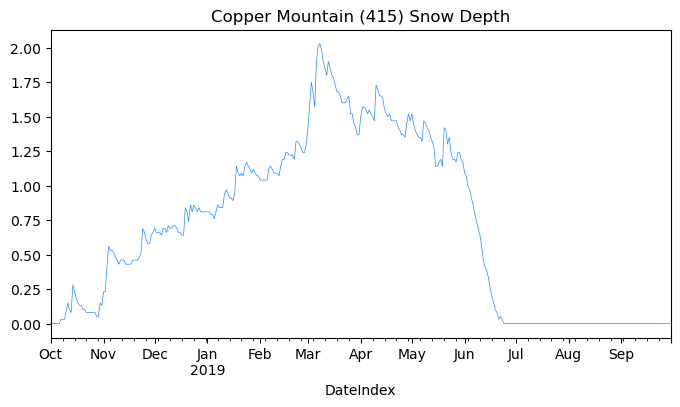

In [15]:
figsize = (8,4)
fig, ax = plt.subplots (1, figsize=figsize)
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=linewidth, 
                                                                color=snotelcolors[0], 
                                                                marker=marker
                                                                )

plt.title(f'{sitename} Snow Depth')

# Check MODIS HRRR outputs on their own

## Check out net_solar

In [36]:
basindirs

['/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal',
 '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/blue_river_100m_isnobal_solar_albedo']

In [17]:
%%time
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
month = 'run20'
days = h.fn_list(basindirs[0], f"*/*/{month}*/smrf_energy_balance*.nc")
# days = h.fn_list(basindirs[0], f"*/*/{month}*/net_solar.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/net_solar.nc")]

# Read in datasets
isnobal_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
modis_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

len(days[0]), len(days[1])

CPU times: user 8.83 s, sys: 7.02 s, total: 15.8 s
Wall time: 40.9 s


(365, 365)

In [18]:
len(days[0]), len(days[1])

(365, 365)

In [19]:
# Pull net_solar
thisvar = 'net_solar'
var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in isnobal_hrrr_list]
updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in modis_hrrr_list]

# Concatenate all the days
var_data = xr.concat(var_data, dim='time')
updated_var_data = xr.concat(updated_var_data, dim='time')


In [20]:
figsize = (18, 4)
linestyles = ['-', '--']
linewidth = 1
marker = None
color = 'k'
snotelcolors = ['dodgerblue', 'gray']
isnobalcolors = ['k', 'coral']

In [21]:
# Loop through the original net solar for a quick check
net_hrrr_modis = f'/uufs/chpc.utah.edu/common/home/skiles-group3/SMESHR/{basin.split('_')[0]}/net_HRRR_MODIS'
computed_net_solar_list = h.fn_list(net_hrrr_modis, 'net_dswrf*.nc')
len(computed_net_solar_list)

365

In [22]:
%%time
# Read in the net_dswrf files
thisvar = 'net_solar'
computed_net_solar_ds_list = [xr.open_dataset(fn) for fn in computed_net_solar_list]
computed_net_solar_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in computed_net_solar_ds_list]
computed_net_solar_data = xr.concat(computed_net_solar_data, dim='time')

CPU times: user 20.2 s, sys: 2.8 s, total: 23 s
Wall time: 34.1 s


Text(0.5, 1.0, 'net_solar')

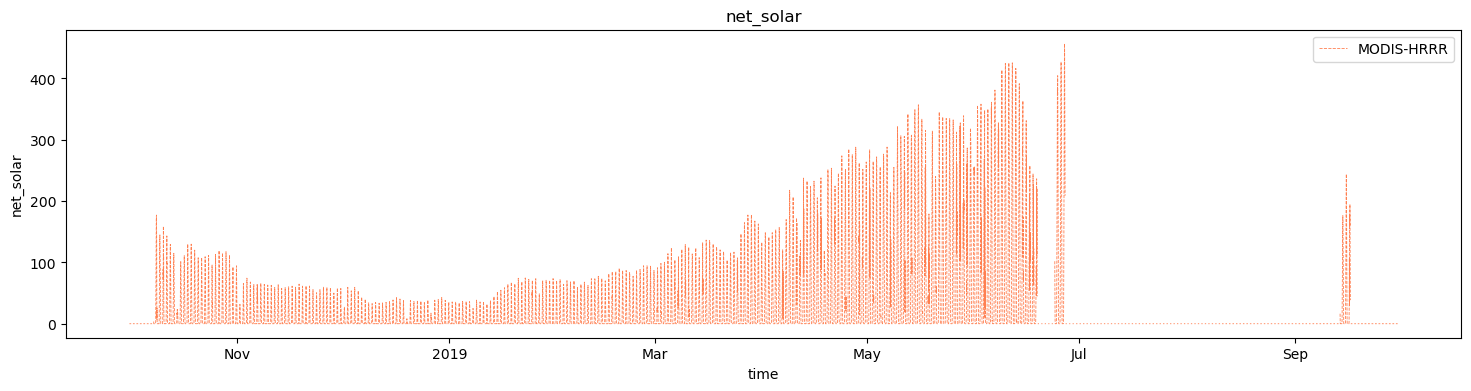

In [23]:
fig, ax = plt.subplots(1, figsize=(18, 4))
# var_data.plot(ax=ax, 
#             #   linestyle=linestyles[0], 
#               color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
computed_net_solar_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar)

CPU times: user 30.2 s, sys: 3.64 s, total: 33.8 s
Wall time: 45.3 s


Text(0.5, 1.0, 'albedo')

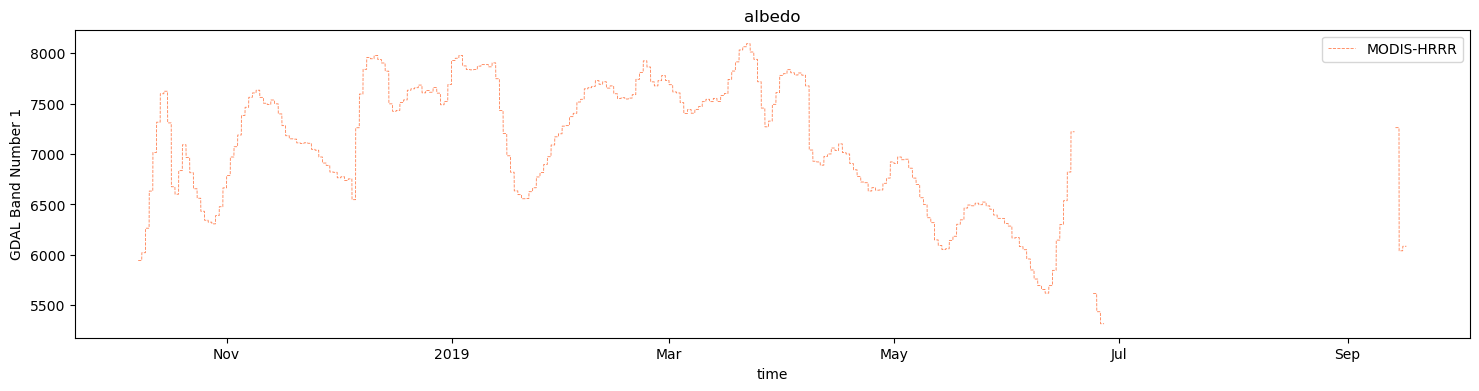

In [24]:
%%time
# Read in the albedo data
thisvar = 'albedo'
computed_net_solar_ds_list = [xr.open_dataset(fn) for fn in computed_net_solar_list]
computed_net_solar_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in computed_net_solar_ds_list]
computed_net_solar_data = xr.concat(computed_net_solar_data, dim='time')

fig, ax = plt.subplots(1, figsize=(18, 4))
# var_data.plot(ax=ax, 
#             #   linestyle=linestyles[0], 
#               color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
computed_net_solar_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar)

CPU times: user 11.5 s, sys: 948 ms, total: 12.5 s
Wall time: 13.5 s


(0.0, 2000.0)

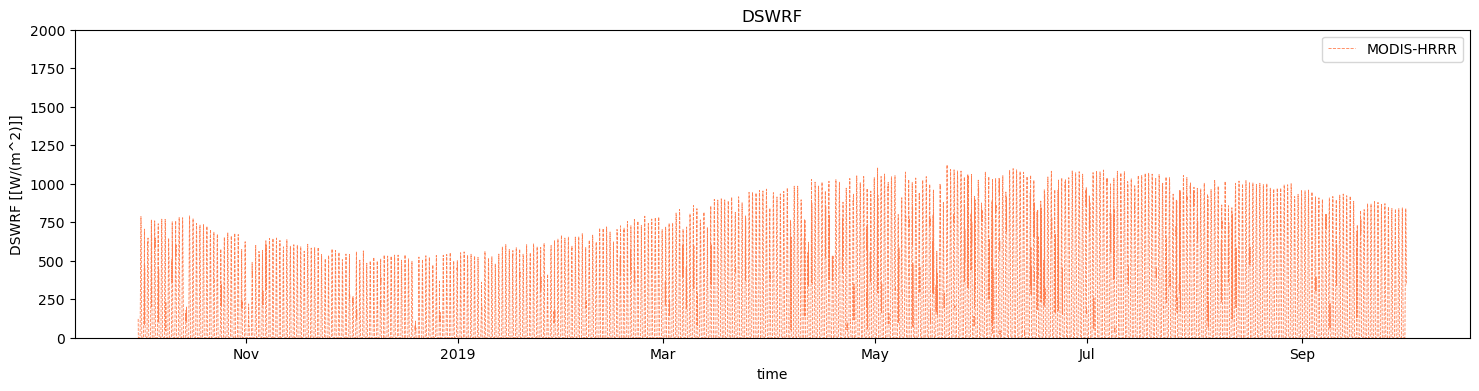

In [25]:
%%time
# Read in the albedo data
thisvar = 'DSWRF'
computed_net_solar_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in computed_net_solar_ds_list]
computed_net_solar_data = xr.concat(computed_net_solar_data, dim='time')

fig, ax = plt.subplots(1, figsize=(18, 4))
# var_data.plot(ax=ax, 
#             #   linestyle=linestyles[0], 
#               color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
computed_net_solar_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar)
plt.ylim(0, 2e3)

CPU times: user 21.7 s, sys: 2.03 s, total: 23.8 s
Wall time: 30 s


Text(0.5, 1.0, 'illumination_angle')

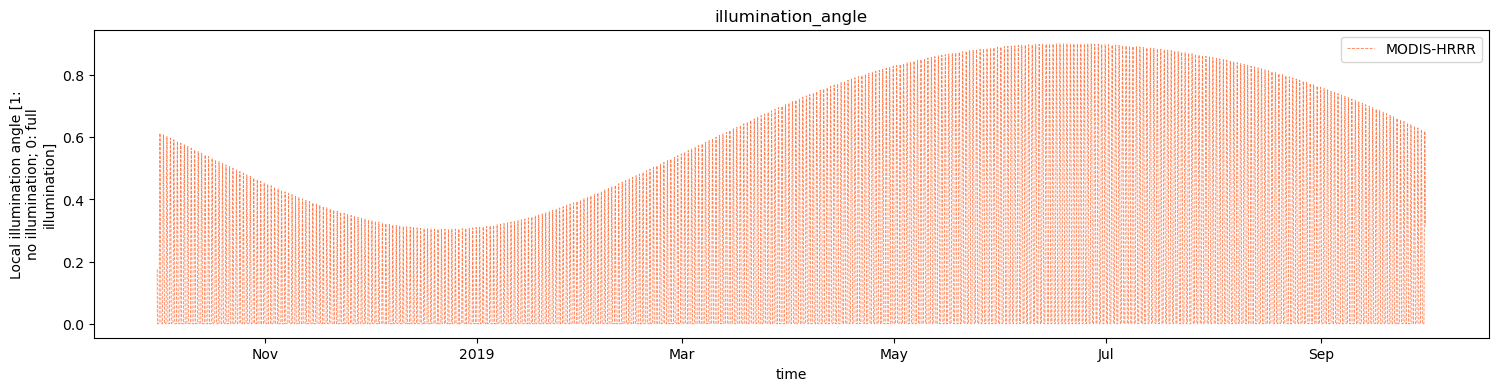

In [26]:
%%time
# Read in the albedo data
thisvar = 'illumination_angle'
computed_net_solar_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in computed_net_solar_ds_list]
computed_net_solar_data = xr.concat(computed_net_solar_data, dim='time')

fig, ax = plt.subplots(1, figsize=(18, 4))
# var_data.plot(ax=ax, 
#             #   linestyle=linestyles[0], 
#               color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
computed_net_solar_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar)

## Plot of net solar comparisons

Text(0.5, 1.0, 'illumination_angle')

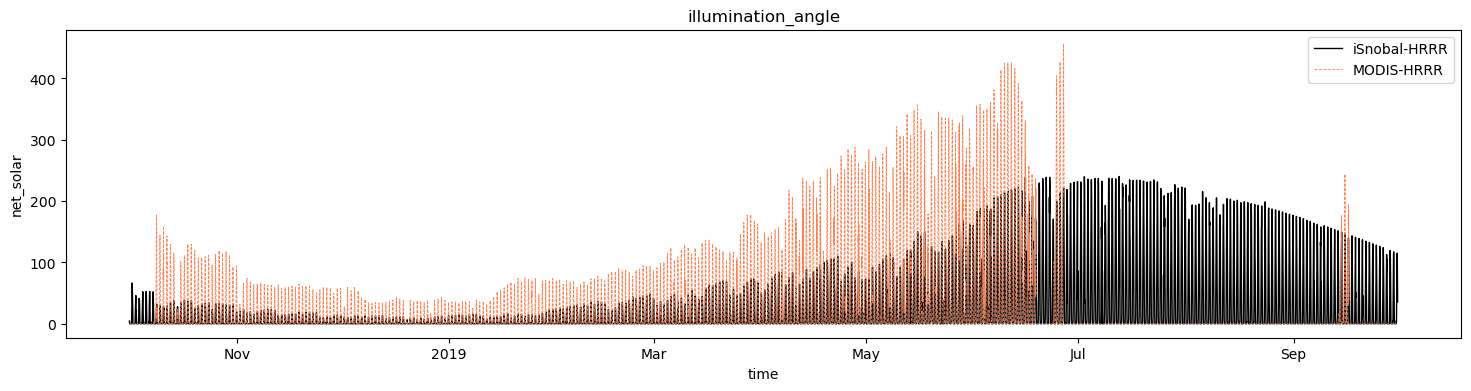

In [27]:
fig, ax = plt.subplots(1, figsize=figsize)
var_data.plot(ax=ax, 
            #   linestyle=linestyles[0], 
              color=isnobalcolors[0], label='iSnobal-HRRR', linewidth=1) 
updated_var_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6)

plt.legend()
plt.title(thisvar)

## Check out cloud factor

In [28]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
days = h.fn_list(basindirs[0], f"*/*/{month}*/cloud_factor.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/cloud_factor.nc")]
len(days)

2

In [29]:
%%time
cloud_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
tcdc_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

CPU times: user 6.87 s, sys: 1.45 s, total: 8.31 s
Wall time: 20.5 s


In [30]:
%%time
thisvar = 'Cloud Factor'
cloud_var_data = [ds['cloud_factor'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in cloud_list]
cloud_updated_var_data = [ds['TCDC'].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in tcdc_list]

# Concatenate all the days
cloud_var_data = xr.concat(cloud_var_data, dim='time')
cloud_updated_var_data = xr.concat(cloud_updated_var_data, dim='time')

CPU times: user 11.1 s, sys: 5.54 s, total: 16.6 s
Wall time: 45.7 s


Text(0.5, 1.0, 'Cloud Factor MODIS-HRRR - iSnobal-HRRR')

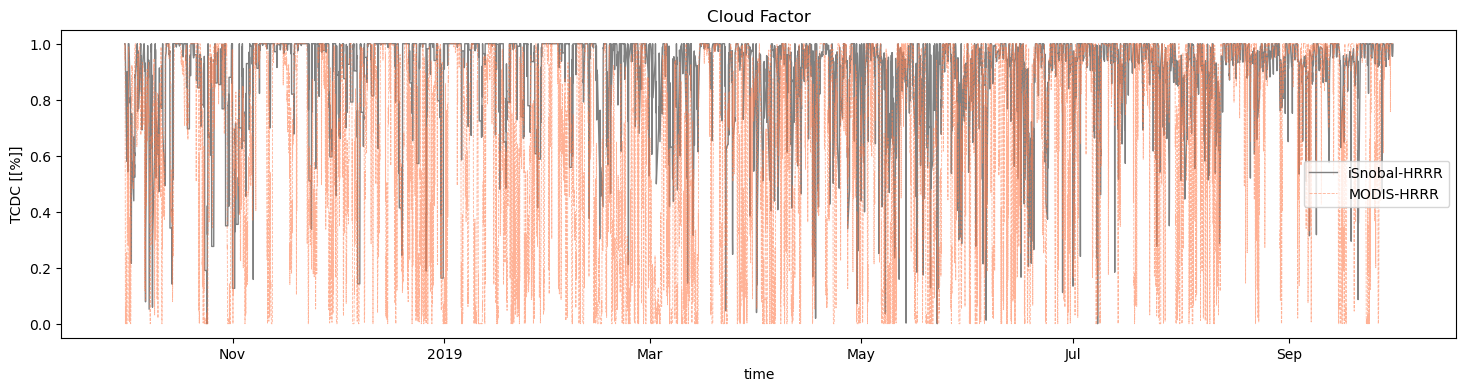

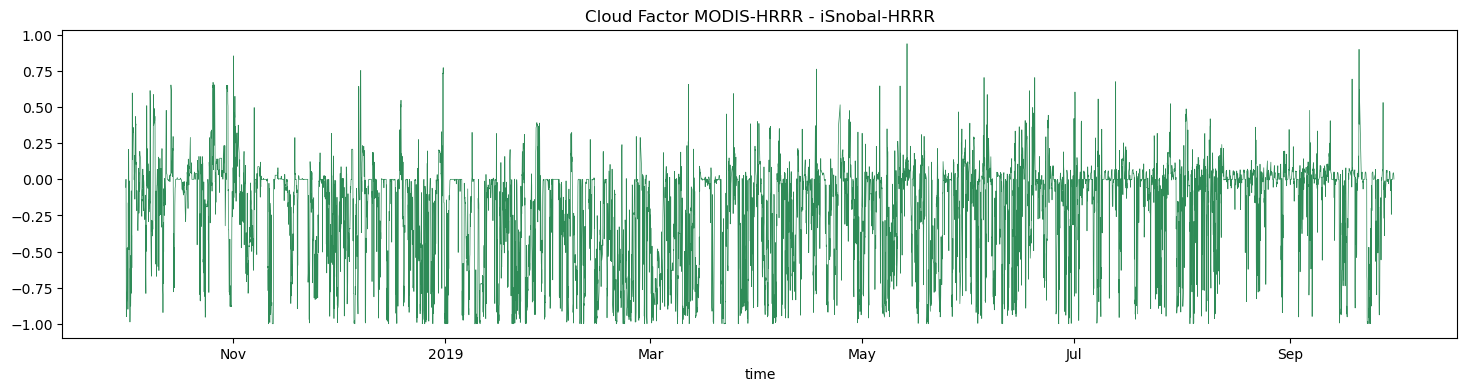

In [31]:
fig, ax = plt.subplots(1, figsize=figsize)
cloud_var_data.plot(ax=ax, 
            #   linestyle=linestyles[0], 
              color='gray', label='iSnobal-HRRR', linewidth=1) 
cloud_updated_var_data.plot(ax=ax, linestyle=linestyles[1], color=isnobalcolors[1], label='MODIS-HRRR', linewidth=0.6, alpha=0.6
                      )
plt.legend()
plt.title(thisvar)

(cloud_updated_var_data - cloud_var_data).plot(figsize=figsize, color='seagreen', linewidth=0.5)
plt.title(f'{thisvar} MODIS-HRRR - iSnobal-HRRR')

# Check state values now

## Snow depth

In [32]:
# currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
days = h.fn_list(basindirs[0], f"*/*/{month}*/snow.nc")
days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/snow.nc")]
len(days)

2

In [33]:
%%time
ds_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
ds_sol_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

thisvar = 'thickness'
snow_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_list]
snow_updated_var_data = [ds[thisvar].sel(x=list(gdf.geometry.x.values), y=list(gdf.geometry.y.values), method='nearest') for ds in ds_sol_list]

# Concatenate all the days
snow_var_data = xr.concat(snow_var_data, dim='time')
snow_updated_var_data = xr.concat(snow_updated_var_data, dim='time')

CPU times: user 22.3 s, sys: 5.86 s, total: 28.2 s
Wall time: 1min 26s


In [34]:
# Get disappearance dates
import processing as proc

snow_name = 'Snow Depth'
verbose = False
day_thresh = 2

snotel_sdd, _ = proc.calc_sdd(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100, 
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(snotel_sdd)
# Convert model data to Pandas Series
classic_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(snow_var_data.data), index=snow_var_data.time.values),
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(classic_sdd)

# Convert model data to Pandas Series
modis_hrrr_sdd, _ = proc.calc_sdd(pd.Series(data=np.squeeze(snow_updated_var_data.data), index=snow_updated_var_data.time.values),
                              snow_name=snow_name, verbose=verbose, day_thresh=day_thresh)
print(modis_hrrr_sdd)

2019-06-21 00:00:00
2019-07-06 22:00:00
2019-06-02 22:00:00


CPU times: user 40.6 ms, sys: 972 µs, total: 41.6 ms
Wall time: 40.7 ms


Text(2019-06-02 22:00:00, 0.75, '2019-06-02')

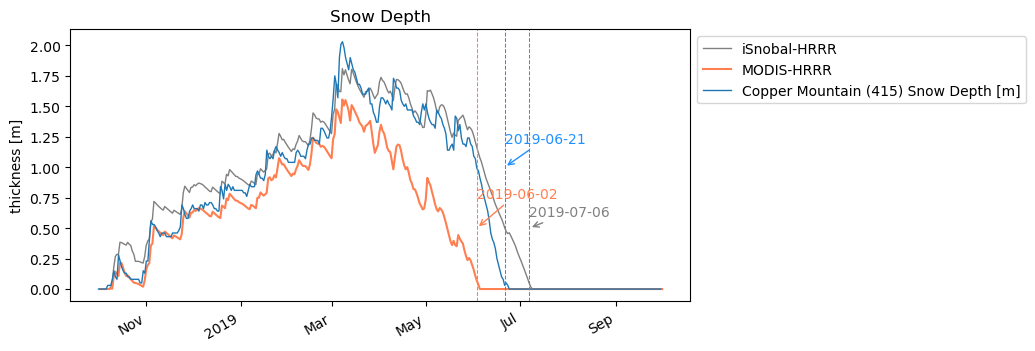

In [35]:
%%time
fig, ax = plt.subplots(1, figsize=(8, 4))
snow_var_data.plot(ax=ax, color='gray', label='iSnobal-HRRR', linewidth=1)
snow_updated_var_data.plot(ax=ax, color=isnobalcolors[1], label='MODIS-HRRR')

# Plot WY time series of snow depth
(snotel_df[f'{sitename} Snow Depth (cm) End of Day Values']/100).plot(ax=ax, 
                                                                label=f'{sitename} Snow Depth [m]', 
                                                                linestyle=linestyle, 
                                                                linewidth=linewidth, 
                                                                # color=snotelcolors[0], 
                                                                marker=marker)

plt.legend(bbox_to_anchor=(1,1))
plt.title('Snow Depth')
plt.xlabel('')

# Add callouts of disappearance dates with vertical lines
plt.axvline(snotel_sdd, color=snotelcolors[0], linestyle='--', linewidth=0.75, label='SNOTEL SDD')
plt.axvline(classic_sdd, color='gray', linestyle='--', linewidth=0.75, label='iSnobal-HRRR SDD')
plt.axvline(modis_hrrr_sdd, color='coral', linestyle='--', linewidth=0.75, label='MODIS-HRRR SDD')

# Add arrows pointing left towards the vertical lines above, in the same color as the line
plt.annotate(f'{snotel_sdd.strftime("%Y-%m-%d")}', xy=(snotel_sdd, 1), xytext=(snotel_sdd, 1.2),
             color=snotelcolors[0], arrowprops=dict(color=snotelcolors[0], arrowstyle='->'))
plt.annotate(f'{classic_sdd.strftime("%Y-%m-%d")}', xy=(classic_sdd, 0.5), xytext=(classic_sdd, 0.6),
             color='gray', arrowprops=dict(color='gray', arrowstyle='->'))
plt.annotate(f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', xy=(modis_hrrr_sdd, 0.5), xytext=(modis_hrrr_sdd, 0.75),
             color='coral', arrowprops=dict(color='coral', arrowstyle='->'))

# Annotate with dates of disappearance dates abbreviating to YYYMMDD

# plt.text(snotel_sdd, 1.5, f'{snotel_sdd.strftime("%Y-%m-%d")}', horizontalalignment='left', color=snotelcolors[0])
# plt.text(classic_sdd, 0.5, f'{classic_sdd.strftime("%Y-%m-%d")}', horizontalalignment='left', color='gray')
# plt.text(modis_hrrr_sdd, 2.5, f'{modis_hrrr_sdd.strftime("%Y-%m-%d")}', horizontalalignment='left', color='coral')

0 302


NameError: name 'modis_hrrr_list' is not defined

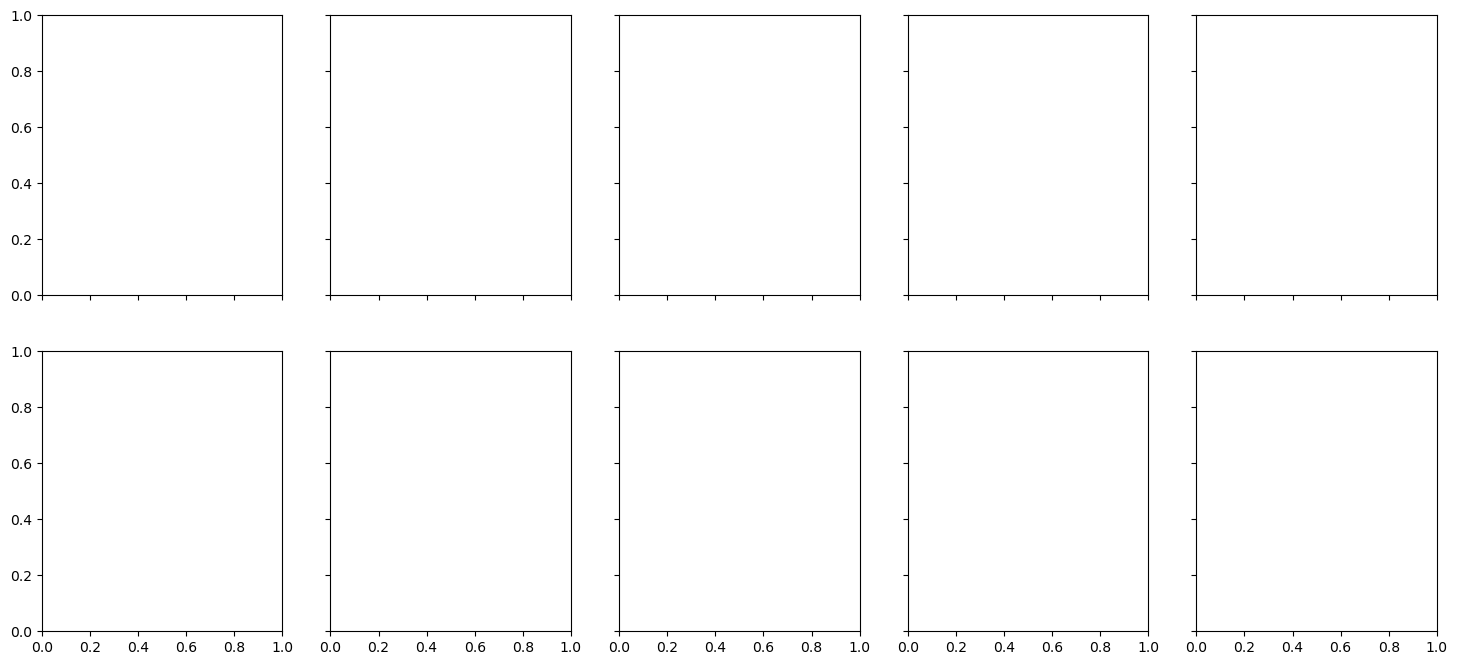

In [7]:
%%time
fig, axa = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
for jdx, f in enumerate(np.random.choice(np.arange(0, 365), 10)):
    print(jdx, f)
    ax = axa.flatten()[jdx]
    modis_hrrr_list[f].isel(time=14).albedo.plot(ax=ax)
    ax.set_xlabel('')
    ax.set_ylabel('')
    # ax.set_xticks([])
# modis_hrrr_list[167].isel(time=14).albedo.plot()

In [8]:
# Plot the original?
dt = 20190718
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo.tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc


<xarray.Dataset> Size: 138MB
Dimensions:      (x: 7200, y: 4800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -1.112e+07 -1.112e+07 ... -7.784e+06
  * y            (y) float64 38kB 5.56e+06 5.559e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 138MB ...

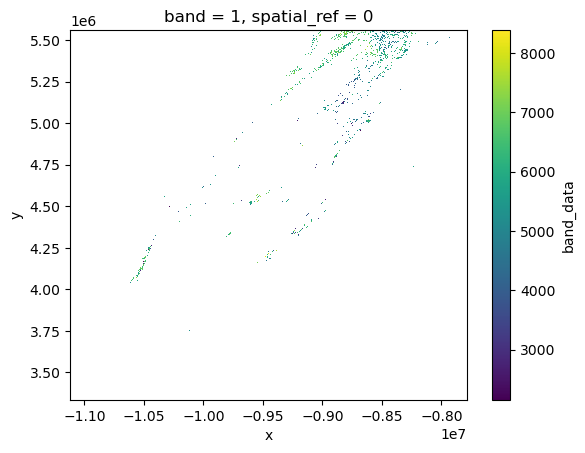

In [9]:
stc.band_data.plot.imshow()

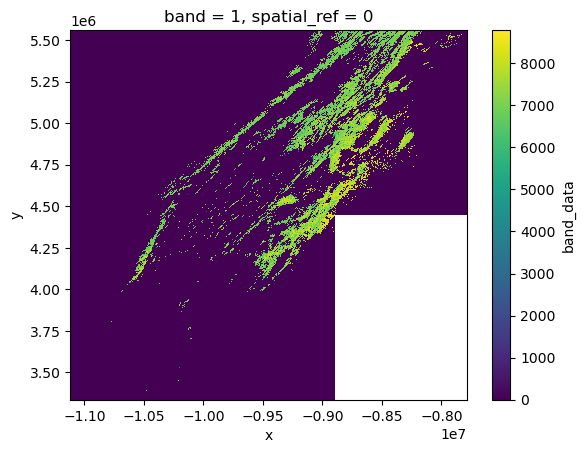

In [10]:
# Plot the original?
dt = '20210421'
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_albedo/wy2021/'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo*tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc.band_data.plot.imshow()


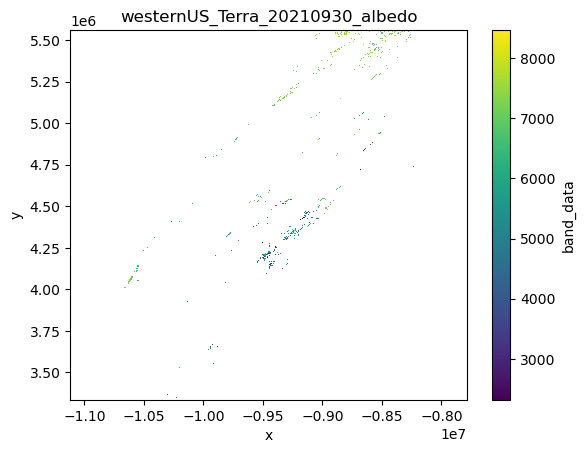

In [38]:
from pathlib import PurePath
# Plot the original?
dt = '20210930'
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo.tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc.band_data.plot.imshow()
plt.title(PurePath(stc_fn).stem);

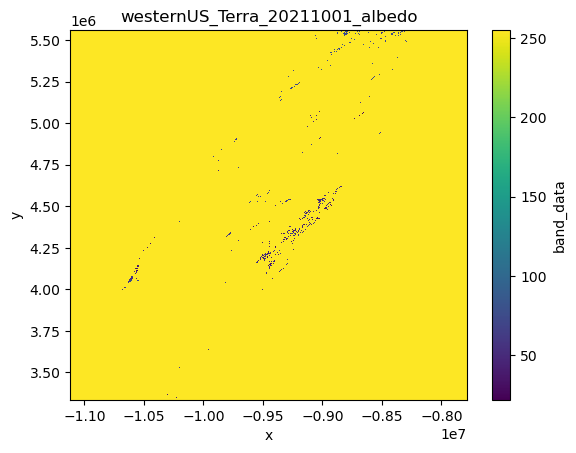

In [39]:
# Plot the original?
dt = '20211001'
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo.tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
stc.band_data.plot.imshow()
plt.title(PurePath(stc_fn).stem);

- WY 2022 onward switches to 0–255 range while maintaining a encoded 65535 no data value when 255 is clearly NDV
- previous to that, valid range appears to be from 0-10000, with encoded nodata value of 65535

### Test from the matlab version

In [61]:
!conda install h5py -y

Retrieving notices: ...working... done
Channels:
 - conda-forge
 - defaults
Platform: linux-64
Solving environment: done

## Package Plan ##

  environment location: /uufs/chpc.utah.edu/common/home/u6058223/software/pkg/miniconda3/envs/work

  added / updated specs:
    - h5py


The following NEW packages will be INSTALLED:

  h5py               conda-forge/linux-64::h5py-3.11.0-nompi_py312hb7ab980_102 

The following packages will be UPDATED:

  ca-certificates    pkgs/main::ca-certificates-2024.7.2-h~ --> conda-forge::ca-certificates-2024.7.4-hbcca054_0 
  openssl                                  3.3.1-h4ab18f5_0 --> 3.3.1-h4bc722e_2 

The following packages will be SUPERSEDED by a higher-priority channel:

  certifi            pkgs/main/linux-64::certifi-2024.7.4-~ --> conda-forge/noarch::certifi-2024.7.4-pyhd8ed1ab_0 




Preparing transaction: done
Verifying transaction: done
Executing transaction: done


In [23]:
import h5py

from osgeo import gdal, gdalconst, gdal_array
GDAL_GTIFF = 'GTiff'
GDAL_VRT = 'VRT'
GTIFF_DRIVER = gdal.GetDriverByName(GDAL_GTIFF)
GTIFF_DRIVER_OPTS = [
    "COMPRESS=LZW",
    "TILED=YES",
    "BIGTIFF=IF_SAFER",
    "NUM_THREADS=ALL_CPUS"
]


BAND_DATA_TYPE = gdalconst.GDT_UInt16
BAND_NO_DATA_VALUE = 65535
BAND_NUMBER = 1

PROJ = '+proj=sinu +lon_0=0 +x_0=0 +y_0=0 +a=6371007.181 +b=6371007.181 +units=m +no_defs'

def matlab_to_geotiff(matlab_file, output_file, template_file, variable):
    #Create an empty geotiff to put the data in
    template_file = gdal.Open(template_file)
    geotiff = GTIFF_DRIVER.Create(
        output_file,
        template_file.RasterXSize, template_file.RasterYSize,
        BAND_NUMBER, BAND_DATA_TYPE,
        options = GTIFF_DRIVER_OPTS)
    geotiff.SetGeoTransform(template_file.GetGeoTransform())
    geotiff.SetProjection(PROJ)
    
    modis_band = geotiff.GetRasterBand(BAND_NUMBER)
    modis_band.SetNoDataValue(BAND_NO_DATA_VALUE)
    
    data_file = h5py.File(matlab_file)
    gdal_array.BandWriteArray(modis_band, np.array(data_file[variable]).T)
    modis_band.ComputeStatistics(0)
    modis_band.FlushCache()
    
    del data_file
    del modis_band
    del geotiff
    del template_file
    return output_file

In [24]:
from pathlib import PurePath

In [25]:
dt = '20220120'

In [26]:
dt

'20220120'

/uufs/chpc.utah.edu/common/home/u6058223/public_html/20220120_albedo_v03.tif


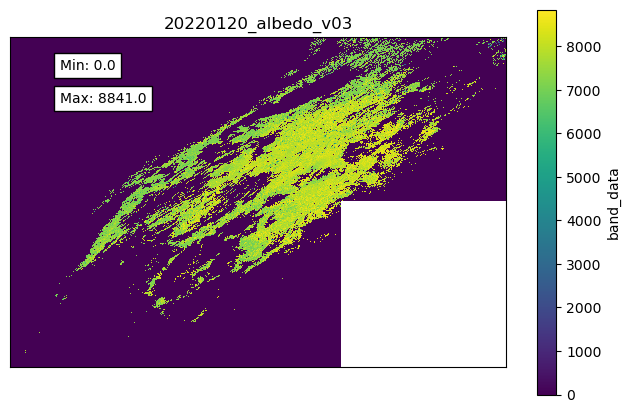

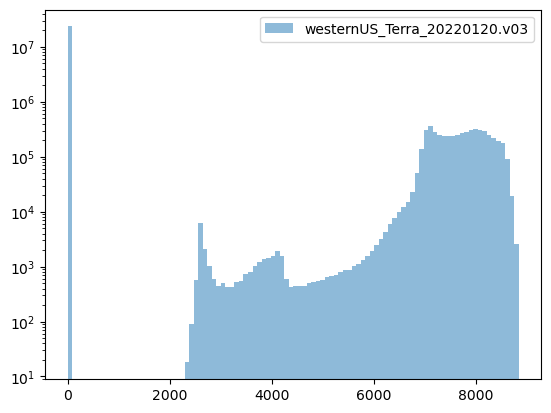

In [68]:
# only up to WY 2022
stc_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v03/'
stc_fn = h.fn_list(stc_dir, f'*/*{dt}*mat')[0]
output_file = f"/uufs/chpc.utah.edu/common/home/u6058223/public_html/{dt}_albedo_{stc_dir.split('/')[-2].split('_')[-1]}.tif"
template_file = '/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/snow-rs/src/snow_rs/data/modis/WesternUS.tif'
variable = 'albedo_observed_muZ'
print(output_file)
if not os.path.exists(output_file):
    matlab_to_geotiff(stc_fn, output_file, template_file, variable)

stc_v03 = np.squeeze(xr.open_dataset(output_file))
fig, ax = plt.subplots(1, figsize=(8,5))

arr = stc_v03.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v06/2022/westernUS_Terra_20220120.v2023.0.mat
/uufs/chpc.utah.edu/common/home/u6058223/public_html/20220120_albedo_v06.tif


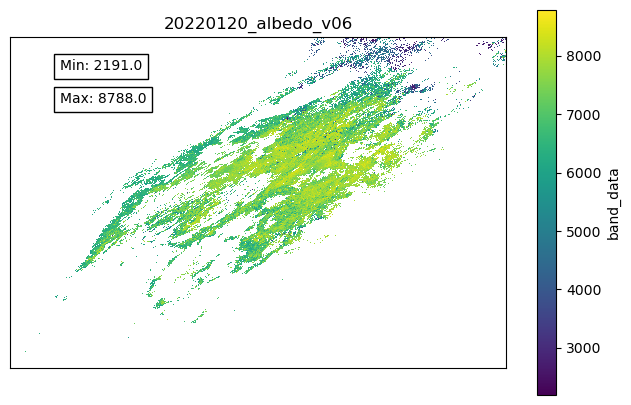

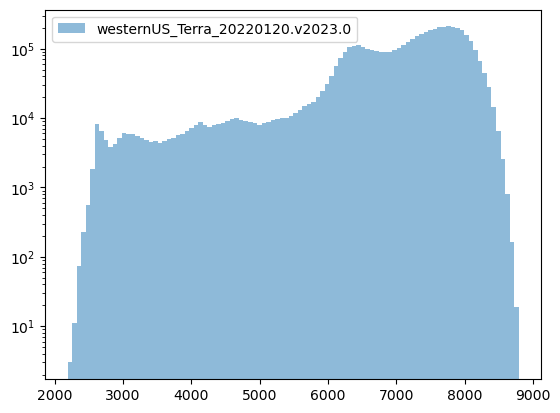

In [69]:
# Up to 2023
stc_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v06/'
stc_fn = h.fn_list(stc_dir, f'*/*{dt}*mat')[0]
print(stc_fn)
output_file = f"/uufs/chpc.utah.edu/common/home/u6058223/public_html/{dt}_albedo_{stc_dir.split('/')[-2].split('_')[-1]}.tif"
template_file = '/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/snow-rs/src/snow_rs/data/modis/WesternUS.tif'
variable = 'albedo_observed_muZ'
print(output_file)
if not os.path.exists(output_file):
    matlab_to_geotiff(stc_fn, output_file, template_file, variable)

stc = np.squeeze(xr.open_dataset(output_file))
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

/uufs/chpc.utah.edu/common/home/u6058223/public_html/20220120_albedo_v2023.0e.tif


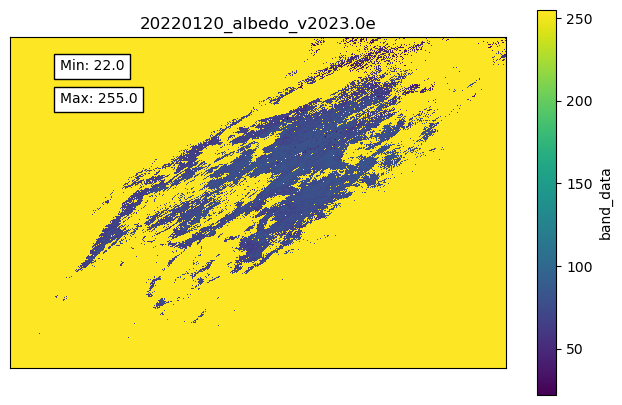

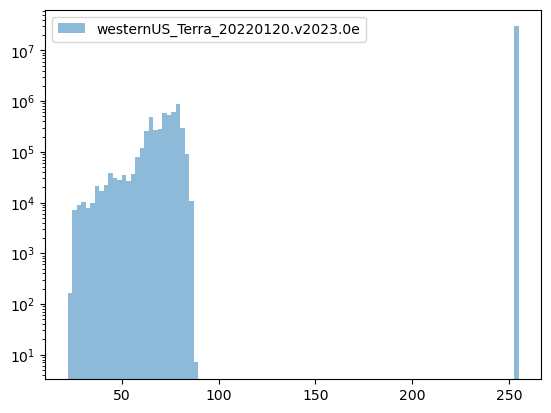

In [70]:
# 2021 through 2023
stc_dir = '/uufs/chpc.utah.edu/common/home/skiles-group1/MODIS_gap-filled/CUB-originals_v2023.0e/'
stc_fn = h.fn_list(stc_dir, f'*/*{dt}*mat')[0]
output_file = f"/uufs/chpc.utah.edu/common/home/u6058223/public_html/{dt}_albedo_{stc_dir.split('/')[-2].split('_')[-1]}.tif"
template_file = '/uufs/chpc.utah.edu/common/home/u6058223/git_dirs/snow-rs/src/snow_rs/data/modis/WesternUS.tif'
variable = 'albedo_observed_muZ'
print(output_file)
if not os.path.exists(output_file):
    matlab_to_geotiff(stc_fn, output_file, template_file, variable)

stc = np.squeeze(xr.open_dataset(output_file))
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

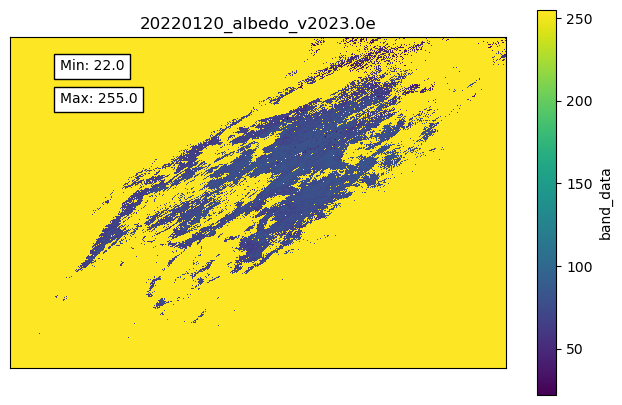

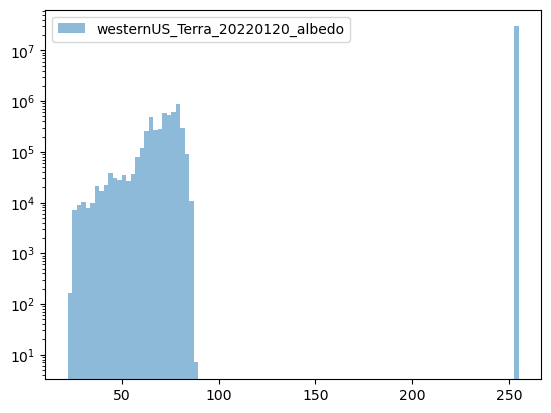

In [71]:
# through calendar WY 2023
# v2023.0e
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo*tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

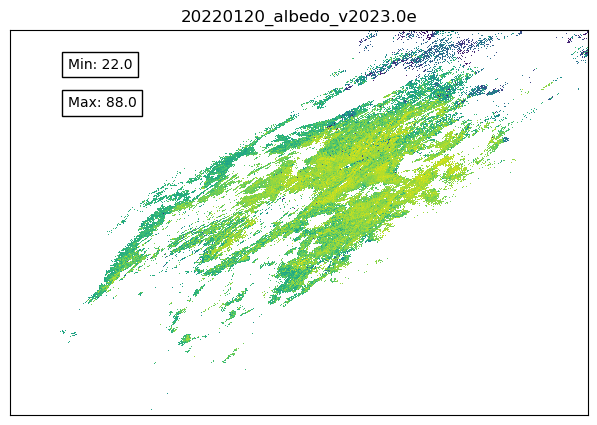

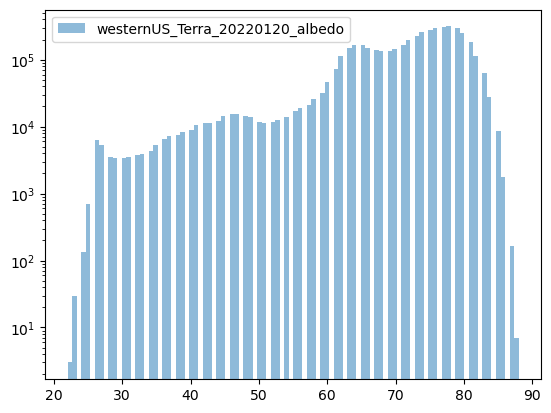

In [73]:
# through calendar WY 2023
# v2023.0e
stc_masked = np.ma.masked_equal(stc.band_data.data, 255)
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_masked
ax.imshow(arr, interpolation='None')
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# Add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation='None'))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

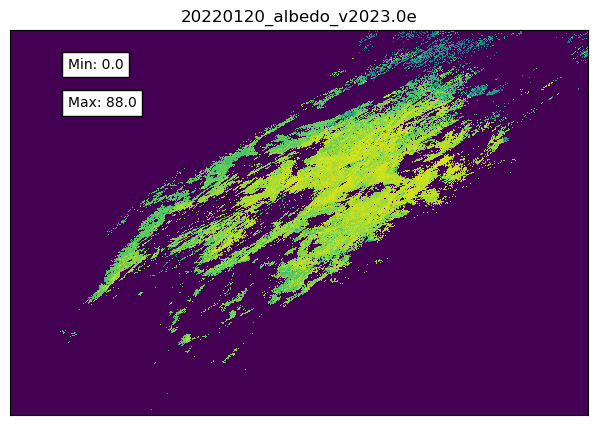

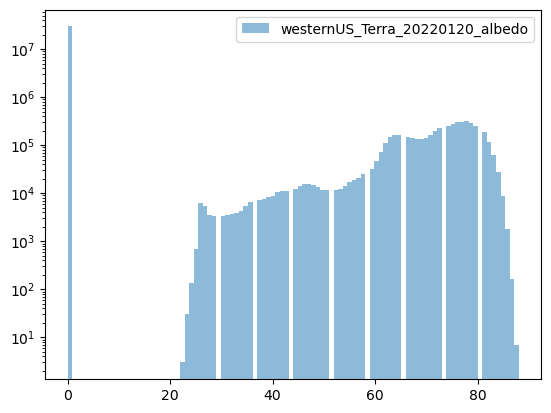

In [74]:
# through calendar WY 2023
# v2023.0e
import copy
stc_reset = copy.deepcopy(stc.band_data.data)
stc_reset[stc_reset==255] = 0

fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_reset
ax.imshow(arr, interpolation='None')
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# Add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation='None'))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

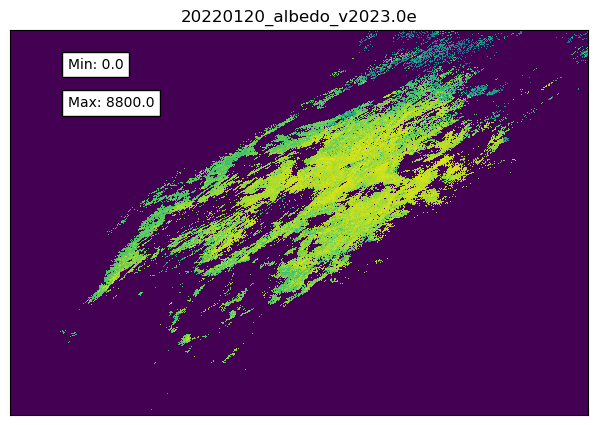

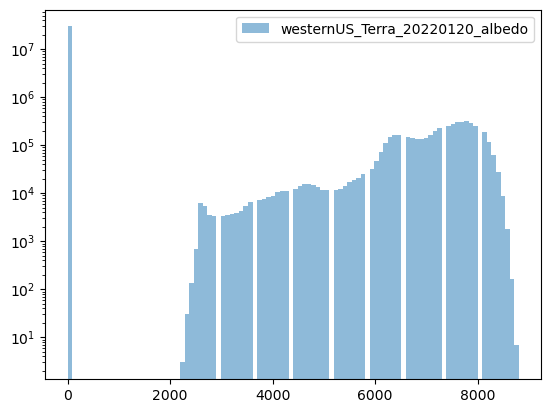

In [75]:
stc_reset_100 = stc_reset * 100
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_reset_100
ax.imshow(arr, interpolation='None')
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# Add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation='None'))

plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [53]:
diff = stc_reset_100 - stc_v03.band_data.data
diff.shape

(4800, 7200)

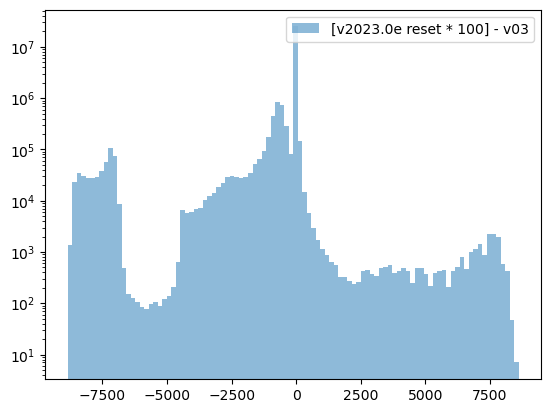

In [78]:
plt.figure()
plt.hist(diff.flatten(), bins=100, alpha=0.5, label='[v2023.0e reset * 100] - v03');
plt.yscale('log')
plt.legend();

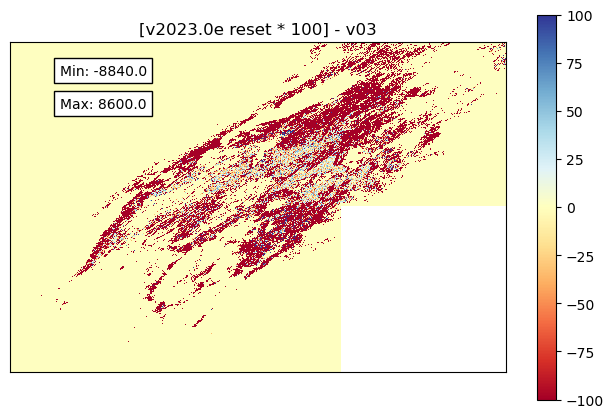

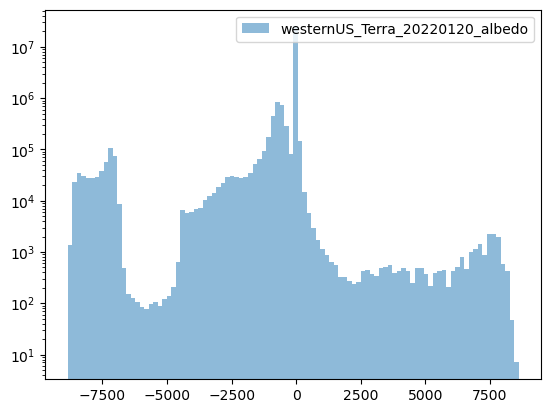

In [85]:
fig, ax = plt.subplots(1, figsize=(8,5))
arr = diff
interpolation='None'
cmap='RdYlBu'
vmin=-100
vmax=100
ax.imshow(arr, interpolation=interpolation, cmap=cmap, vmin=vmin, vmax=vmax)
plt.title('[v2023.0e reset * 100] - v03');

# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
# add colorbar
cbar = plt.colorbar(ax.imshow(arr, interpolation=interpolation, cmap=cmap, vmin=vmin, vmax=vmax))
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [87]:
type(stc), type(stc.band_data), type(stc.band_data.data)

(xarray.core.dataset.Dataset, xarray.core.dataarray.DataArray, numpy.ndarray)

In [88]:
def reset_and_rescale(ds, ndv=255, scale=100, varname='band_data'):
    ''' Rescale v2023.0e MODSCAG albedo to v03 standards
    Range: 0-10000
    NDV: 0
    arr: xarray.core.dataset.Dataset
    '''
    # Create a deep copy of the array 
    ds_reset = copy.deepcopy(ds)

    # Extract numpy array
    arr = ds_reset[varname].data
    
    # Reset ndv to 0
    arr[arr==ndv] = 0

    # Rescale to 0-10000 and assign to the dataset
    ds_reset[varname].data = arr * scale

    return ds_reset

In [89]:
# through calendar WY 2023
# v2023.0e
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group2/MODIS_gap-filled/v2023.0e/albedo'
stc_fn = h.fn_list(stc_dir, f'*{dt}*albedo*tif')[0]
stc = np.squeeze(xr.open_dataset(stc_fn))


stc_from_func = reset_and_rescale(stc)

In [92]:
stc_from_func

<xarray.Dataset> Size: 138MB
Dimensions:      (x: 7200, y: 4800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -1.112e+07 -1.112e+07 ... -7.784e+06
  * y            (y) float64 38kB 5.56e+06 5.559e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 138MB 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0

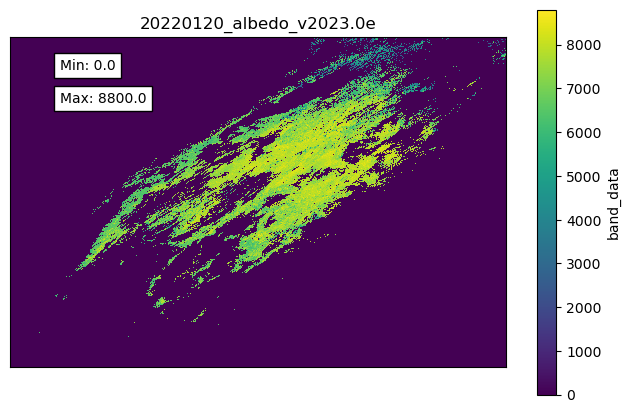

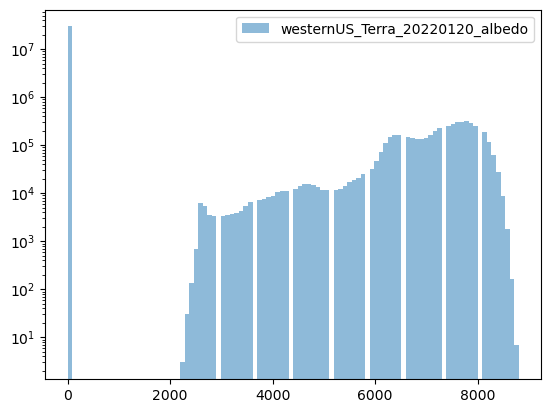

In [93]:
fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc_from_func.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [95]:
import rioxarray as riox

In [96]:
stc_from_func.rio.to_raster('test.tif')

In [99]:
test = np.squeeze(xr.open_dataset('test.tif'))
test

<xarray.Dataset> Size: 138MB
Dimensions:      (x: 7200, y: 4800)
Coordinates:
    band         int64 8B 1
  * x            (x) float64 58kB -1.112e+07 -1.112e+07 ... -7.784e+06
  * y            (y) float64 38kB 5.56e+06 5.559e+06 ... 3.337e+06 3.336e+06
    spatial_ref  int64 8B ...
Data variables:
    band_data    (y, x) float32 138MB ...

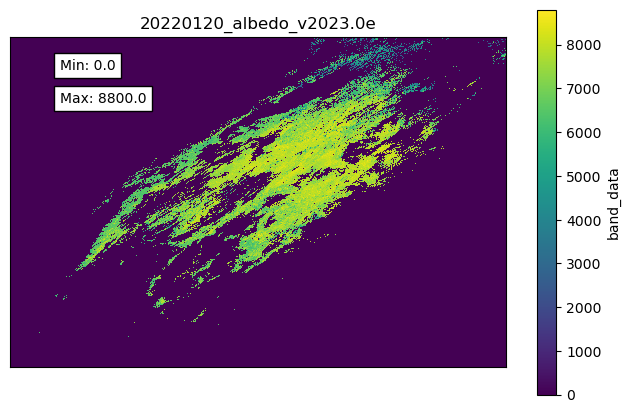

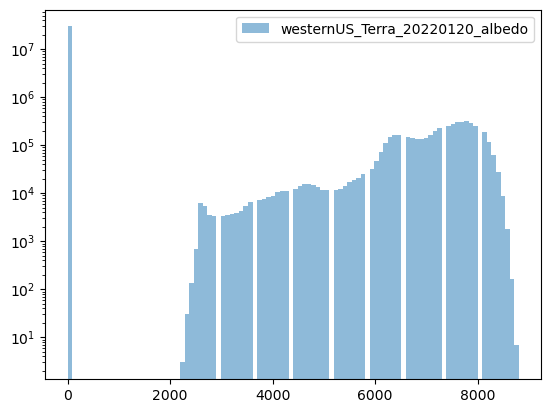

In [101]:
fig, ax = plt.subplots(1, figsize=(8,5))
arr = test.band_data
arr.plot.imshow()
plt.title(PurePath(output_file).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

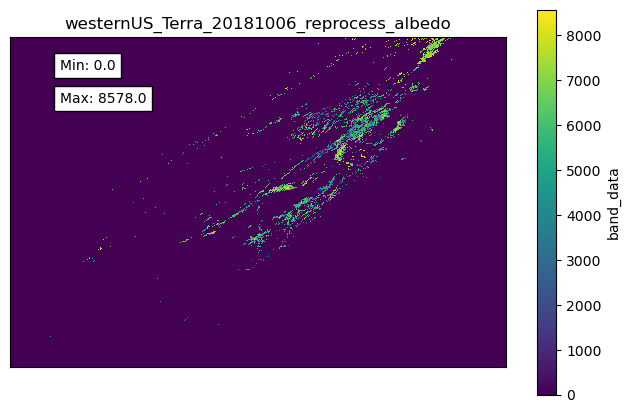

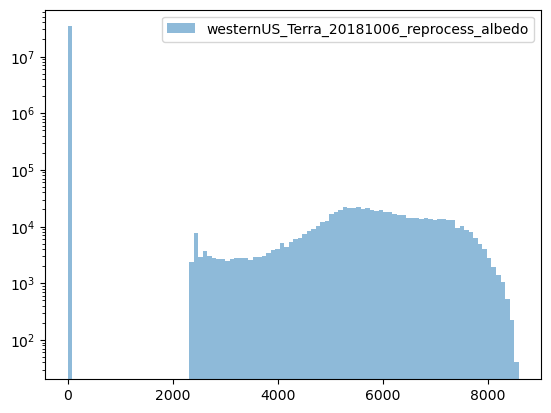

In [107]:
# Check a new one
# through calendar WY 2023
# v2023.0e
stc_dir='/uufs/chpc.utah.edu/common/home/skiles-group3/MODIS_albedo_v2023.0e_JMH_reprocessed/wy2019'
stc_fn = h.fn_list(stc_dir, f'*reprocess*albedo*tif')[5]
stc = np.squeeze(xr.open_dataset(stc_fn))

fig, ax = plt.subplots(1, figsize=(8,5))
arr = stc.band_data
arr.plot.imshow()
plt.title(PurePath(stc_fn).stem);
# Annotate with minimum, maximum values with a background fill
plt.annotate(f'Min: {np.nanmin(arr.data)}', xy=(0.1, 0.9), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'))
plt.annotate(f'Max: {np.nanmax(arr.data)}', xy=(0.1, 0.8), xycoords='axes fraction', bbox=dict(facecolor='white', edgecolor='black'));
ax.set_aspect('equal');
plt.xlabel('')
plt.ylabel('')
plt.xticks([])
plt.yticks([]);

plt.figure()
plt.hist(arr.data.flatten(), bins=100, alpha=0.5, label=f'{PurePath(stc_fn).stem}');
plt.yscale('log')
plt.legend()

In [108]:
%%time
basin = 'blue_river'
workdir = '/uufs/chpc.utah.edu/common/home/skiles-group1/jmhu/model_runs/'
basindirs = h.fn_list(workdir, f'*{basin}*')
print(basindirs)

# # currently for one WY (only one per basin as of 20240618), will need to add more for WYs in the future
# month = 'run20'
# days = h.fn_list(basindirs[0], f"*/*/{month}*/smrf_energy_balance*.nc")
# # days = h.fn_list(basindirs[0], f"*/*/{month}*/net_solar.nc")
# days = [days, h.fn_list(basindirs[1], f"*/*/{month}*/net_solar.nc")]
# print(len(days[0]), len(days[1]))
# # Read in datasets
# isnobal_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[0]]
# modis_hrrr_list = [xr.open_dataset(day_fn) for day_fn in days[1]]

# len(days[0]), len(days[1])


# fig, axa = plt.subplots(2, 5, figsize=(18, 8), sharex=True, sharey=True)
# for jdx, f in enumerate(np.random.choice(np.arange(0, 365), 10)):
#     print(jdx, f)
#     ax = axa.flatten()[jdx]
#     modis_hrrr_list[f].isel(time=14).albedo.plot(ax=ax)
#     ax.set_xlabel('')
#     ax.set_ylabel('')
#     # ax.set_xticks([])
# # modis_hrrr_list[167].isel(time=14).albedo.plot()